<a href="https://colab.research.google.com/github/Nrln12/CarBrandClassification/blob/main/CarBrandClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.utils import load_img , img_to_array, image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/Datasets.zip

Archive:  /content/Datasets.zip
replace Datasets/Audi/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Creating dataset

In [ ]:
data_dir='/content/Datasets'
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3352 files belonging to 7 classes.
Using 2682 files for training.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3352 files belonging to 7 classes.
Using 670 files for validation.


# Visuaazing data

In [ ]:
class_names = train_data.class_names
print(class_names)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


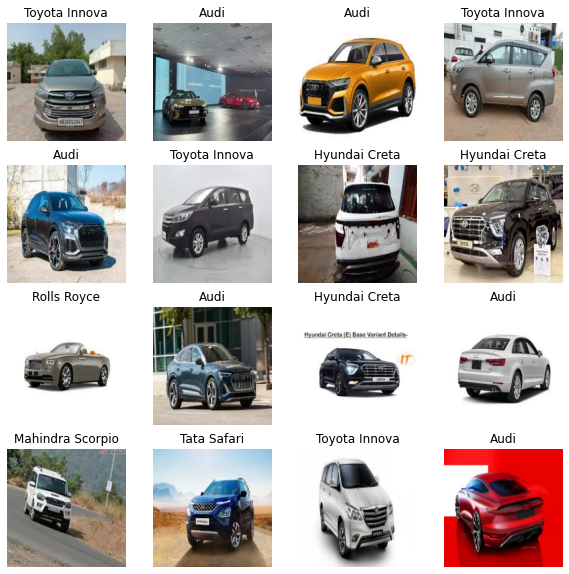

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# Normalazing model

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Crrating model

In [ ]:
num_classes = len(class_names)

car_brand_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
car_brand_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
car_brand_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Training model

overfitting

In [ ]:
epochs=10
history = car_brand_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
84/84 [==============================] - 6s 34ms/step - loss: 1.8128 - accuracy: 0.3158 - val_loss: 1.6402 - val_accuracy: 0.4239
Epoch 2/10
84/84 [==============================] - 2s 21ms/step - loss: 1.4277 - accuracy: 0.5071 - val_loss: 1.3136 - val_accuracy: 0.5313
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 0.9929 - accuracy: 0.6562 - val_loss: 1.1671 - val_accuracy: 0.6209
Epoch 4/10
84/84 [==============================] - 2s 22ms/step - loss: 0.6050 - accuracy: 0.7882 - val_loss: 1.1112 - val_accuracy: 0.6478
Epoch 5/10
84/84 [==============================] - 2s 21ms/step - loss: 0.2718 - accuracy: 0.9120 - val_loss: 1.2031 - val_accuracy: 0.6582
Epoch 6/10
84/84 [==============================] - 2s 21ms/step - loss: 0.0878 - accuracy: 0.9776 - val_loss: 1.6058 - val_accuracy: 0.6642
Epoch 7/10
84/84 [==============================] - 2s 21ms/step - loss: 0.0271 - accuracy: 0.9944 - val_loss: 1.7886 - val_accuracy: 0.6657
Epoch 8/10
84

# Data augmentation


In [ ]:
tf.keras.layers.RandomFlip

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

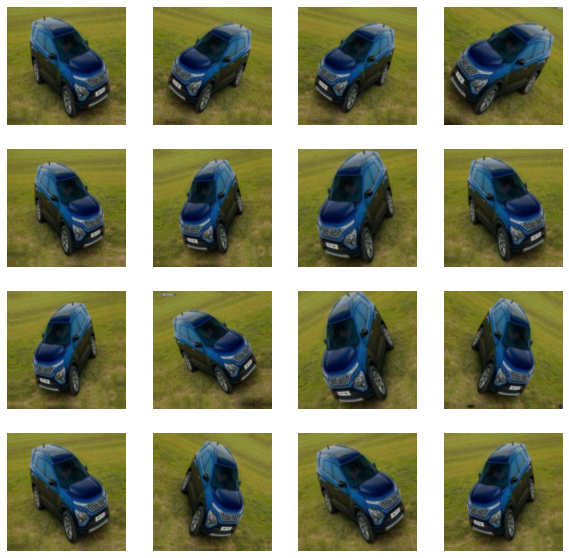

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

In [ ]:
car_brand_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
car_brand_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
car_brand_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = car_brand_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/15
84/84 [==============================] - 2s 25ms/step - loss: 0.7721 - accuracy: 0.7323 - val_loss: 1.0901 - val_accuracy: 0.6418
Epoch 2/15
84/84 [==============================] - 2s 24ms/step - loss: 0.7282 - accuracy: 0.7498 - val_loss: 1.1339 - val_accuracy: 0.6537
Epoch 3/15
84/84 [==============================] - 2s 24ms/step - loss: 0.7008 - accuracy: 0.7502 - val_loss: 1.0610 - val_accuracy: 0.6582
Epoch 4/15
84/84 [==============================] - 2s 26ms/step - loss: 0.6600 - accuracy: 0.7610 - val_loss: 1.2207 - val_accuracy: 0.6358
Epoch 5/15
84/84 [==============================] - 2s 24ms/step - loss: 0.6207 - accuracy: 0.7763 - val_loss: 1.1377 - val_accuracy: 0.6746
Epoch 6/15
84/84 [==============================] - 2s 24ms/step - loss: 0.6188 - accuracy: 0.7837 - val_loss: 1.1269 - val_accuracy: 0.6552
Epoch 7/15
84/84 [==============================] - 2s 24ms/step - loss: 0.5487 - accuracy: 0.8072 - val_loss: 1.0682 - val_accuracy: 0.6881
Epoch 8/15
84

# Predicting

In [ ]:
img = tf.keras.utils.load_img(
    '/content/car_swift.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = car_brand_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Swift with a 99.64 percent confidence.


In [ ]:


img = tf.keras.utils.load_img(
    '/content/Datasets/Hyundai Creta/11.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = car_brand_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Hyundai Creta with a 99.53 percent confidence.


In [ ]:
def car_brand(model):
    objects = ('Audi', 'Hyundai', 'Mahindra', 'Roll', 'Swift', 'Safari', 'Toyota')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, model, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('Car Brand')
    
    plt.show()

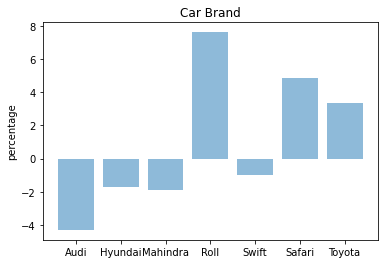

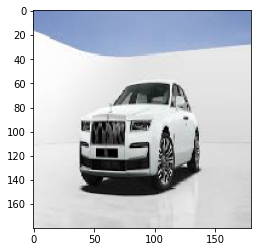

92.89 percent confidence.


In [ ]:

img=load_img('/content/Datasets/Rolls Royce/103.jpg',color_mode="rgb", target_size=(180, 180))

x = img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = car_brand_model.predict(x)
car_brand(custom[0])

x = np.array(x, 'float32')
x = x.reshape([-1,1,180, 180]);

plt.imshow(img)
plt.show()
print(
    "{:.2f} percent confidence."
    .format( 100 * np.max(tf.nn.softmax(custom[0])))
)